# Intro:
The goal of this notebook is to build a neural network from scratch using NumPy only to recognize hand written image, And that's because I belive it will help me to understand deeply how can NN and Deep Learning models train more than just use Deep Learning frameworks.
So let us start!

## 1. What is Machine Learning:
Okay, I know there are a lot of defenation for ML, But I will copy my Favorite:

**"A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P if its performance at tasks in T, as measured by P, improves with experience E."** Tom M. Mitchell

If we applied this to our usecase:
* the task (T) is to take image of digit as an input, and recognize what digit it is.
* the experience (E) is to let our model to see the images of the digits and its corresponding labels (0, 1, 2, ..., 9).
* the performance measure (P) is how good our model classify the digits from its images, Maybe we can use accuarcy as a metric (accuarcy is a percentage of how much our model recognize the label for the image correctly).


So we need to make our model to be able to:
* take the image and predict the digit (Known as forward propagation).
* measure how much our model is good at this task or how much our model get misclassified the digit (Known as Loss function).
* Make the model learn from its mistakes and update itself (using gradient decent | Back propagation).
* repeat the 1st step again, until our model is good.

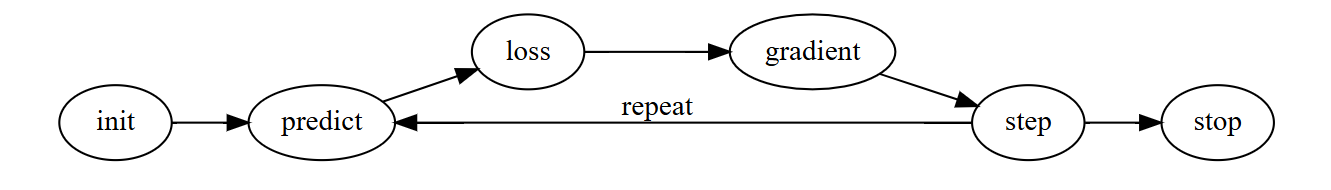

# Import Important libraries and load our dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# Detect if the notebook run on kaggle or localhost
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    path = '../input/digit-recognizer/'
else:
    path = './input/'

In [5]:
train_path = path + 'train.csv'
test_path = path + 'test.csv'

In [6]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df.isna().sum().any()

False

In [9]:
train_df['label'].value_counts()*100/train_df.shape[0]

1    11.152381
7    10.478571
3    10.359524
9     9.971429
2     9.945238
6     9.850000
0     9.838095
4     9.695238
8     9.673810
5     9.035714
Name: label, dtype: float64

The perecntages of different digits is approximatly balanced.

The size of our images is 28 pixels width and 28 pixels height so they flatted 28*28 = 784 pixels.

In [11]:
train_df['pixel300'].value_counts()

0      24676
253     3066
254     1298
252     1236
255      695
       ...  
68        17
136       17
118       16
157       16
77        14
Name: pixel300, Length: 256, dtype: int64

values of pixel from 0 (Black) to 255 (White).

## show samples of dataset:

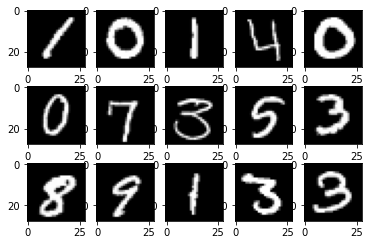

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=5)
image_index = 0
for row in ax:
    for col in row:
        image = train_df.iloc[image_index,1:]
        image = np.array(image, dtype='float')
        pixels = image.reshape((28, 28))
        col.imshow(pixels, cmap='gray')
        image_index += 1

# Start Building NN Architecture:

## 1. Some KG. 1 drawings:

![image.png](./notebook_images/nn_arch.png)

Firstly, Sorry for this high quality drawing, but that's our Neural Network architecture:
1. Input layer (784 nodes, node for each pixel).
2. Hidden layer (10 nodes).
3. Ouput layer (10 nodes, Every node is to output the probability of image being this digit)

## 1. What is the activation function:
The activation function is a non-linear function, we use it to capture a more complex pattern than linear equation can do, and if we don't use it, it doesn't matter how our model has more layers or not because the composition of linear equations will be also a linear regression, but when we add activation function, every layer we add will make our Neural network be more able to capture more complex pattern.

![](./notebook_images/cnn_layers.png)

As we see in the above image, in the first layer it extract a simple feature like (Horizontal edges, Vertical edges, Color gradients), and by going deeper in layers, we find the layers be able to extract more complex features.

### Activation function types:
There are many different activation functions types, but I will use in our architecture the RelU function.
![image.png](./notebook_images/relu.png)


It's a very simple function:
y = max(0,x)
if the x >= 0 : return x
else return 0

### Code the relu function:

In [13]:
def relu(X):
    return np.maximum(0, X)

In [14]:
relu([10, 20, -30, -25, 0])

array([10, 20,  0,  0,  0])

Okay, It is that simple.

## Linear Function (Matrix Multiplication):
![image.png](./notebook_images/perceptron_eq.png)

W is represent weights matrix,

**Columns number:** equal to the number of features we have (in our case, there are 784 feature -> image pixels value).


**Rows number:** equal to the number of nodes, the above drawing is for one node, but next we will make the rows equal to the number of nodes of every layer. 

In [17]:
def linear_function(W, X, b):
    return np.dot(W, X.T) + b

In [18]:
linear_function(np.array([[2, 2], [3, 3], [4, 4]]), np.array([5, 6]), np.array([1, 2, 3]))

array([23, 35, 47])

In [19]:
def perceptron(W, X, b):
    return relu(linear_function(W, X, b))

In [20]:
perceptron(np.array([[2, 2], [3, 3], [4, 4]]), np.array([5, 6]), np.array([1, 2, 3]))

array([23, 35, 47])

## Make layer class:
- every layer has number of nodes.

In [21]:
def initialize_weights(shape, seed=None):
    if seed is not None:
        np.random.seed(seed)
    weights = np.random.randn(*shape) * np.sqrt(2.0 / shape[0])
    return weights

In [22]:
class Layer:
    def __init__(self, number_of_features, number_of_nodes, seed=42):
        self.number_of_features = number_of_features
        self.number_of_nodes = number_of_nodes
        self.weights = initialize_weights((number_of_nodes, number_of_features), seed)
    def get_weights(self):
        return self.weights

In [23]:
first_layer = Layer(2, 3, 42)
first_layer.get_weights()

array([[ 0.40556541, -0.11289233],
       [ 0.52883548,  1.24354867],
       [-0.19118543, -0.19117202]])